# Installation des packages

In [36]:
!pip install pycountry_convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importation des packages



In [37]:
import pandas as pd
import pycountry_convert as pc

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Importer les modèles ici
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Fonctions



In [38]:
def split_date(df, date_column):
  """
  Fonction pour séparer une colonne de dates en jours, mois, années et trimestres.

  Paramètres :
  - df (pandas.DataFrame) : le DataFrame contenant la colonne de dates à séparer.
  - date_column (str) : le nom de la colonne de dates à séparer.

  Retourne :
  - pandas.Series : la colonne des jours.
  - pandas.Series : la colonne des mois.
  - pandas.Series : la colonne des années.
  - pandas.Series : la colonne des trimestres.
  """
  return  df[date_column].dt.day, df[date_column].dt.month, df[date_column].dt.year, df[date_column].dt.quarter


def get_continent(iso_code):
  """
  Fonction pour récupérer le continent à partir du code ISO du pays.

  Paramètres :
  - iso_code (str) : le code ISO à deux lettres du pays.

  Retourne :
  - str : le code du continent (AF, AS, EU, NA, OC, SA, AN) si le code ISO du pays est reconnu, "Inconnue" sinon.
  """

  try:
      return pc.country_alpha2_to_continent_code(iso_code)
  except:
      return "Inconnue"

In [39]:
def load_data():
  """
    Fonction permettant de charger les données du fichier financement.csv, de nettoyer et de faire du feature engineering
  """

  financement_df = pd.read_csv("financement.csv", sep=",", index_col=0) # Lecture du fichier csv
  financement_df = financement_df[~financement_df["etat"].isin(["undefined", "live", "suspended"])] # On exclue les projets avec un état undefined, live ou suspended

  # On ajoute également une colonne etat_int avec une valeur de 0 pour les projets ayant un état failed ou canceled, et 1 pour les projets ayant un état successful
  financement_df["etat_int"] = financement_df["etat"].map({'failed': 0, 'canceled': 0, 'successful': 1})

  # On drop les colonnes en double
  financement_df.drop(["objectif", "promesse", "promesse_usd1"], axis=1, inplace=True)

  # On créer des classes pour éviter que les données extrèmes influencent trop notre modèle
  num_col = ['objectif_usd', 'promesse_usd2', 'supporters']
  for col in num_col:
    col_stats = financement_df[col].describe()
    bins = [
        col_stats.get("min"), 
        col_stats.get("25%"), 
        col_stats.get("50%"), 
        col_stats.get("75%"), 
        col_stats.get("max"), 
    ]

    labels = ['Très faible', 'Faible', 'Moyen', 'Elevé']
    financement_df[f'{col}_cat'] = pd.cut(financement_df[col], bins=bins, labels=labels)
  
  cat_col = [col for col in financement_df.columns if col.endswith("_cat")]
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[cat_col])], axis=1)

  # On convertit les colonnes lancement et date_butoire au format datetime, on calcule la différence entre les deux en jours, et on supprime les projets dont la durée est supérieure à 1000 jours
  financement_df["lancement"] = pd.to_datetime(financement_df["lancement"])
  financement_df["date_butoire"] = pd.to_datetime(financement_df["date_butoire"])
  financement_df['ecart_jours'] = (financement_df['date_butoire'] - financement_df['lancement']).dt.days
  financement_df = financement_df[financement_df["ecart_jours"] < 14000]

  # On utilise la fonction split_date pour séparer les colonnes lancement et date_butoire en jours, mois, années et trimestres
  financement_df["lancement_day"], financement_df["lancement_month"], financement_df["lancement_year"], financement_df["lancement_quarter"] = split_date(financement_df, "lancement")
  financement_df["date_butoire_day"], financement_df["date_butoire_month"], financement_df["date_butoire_year"], financement_df["date_butoire_quarter"] = split_date(financement_df, "date_butoire")

  # On dummifie certaines colonnes
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[["categorie", "categorie_principale"]])], axis=1)
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df["monaie"])], axis=1)
  financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df["pays"])], axis=1)

  # On ajoute une colonne continent en utilisant la fonction get_continent pour récupérer le continent à partir du code ISO du pays, et on supprime les projets avec continent "Inconnue"
  financement_df['continent'] = financement_df['pays'].apply(get_continent)
  financement_df = financement_df[financement_df["continent"] != "Inconnue"]
  financement_df["continent_int"] = financement_df["continent"].map({'NA': 0, 'EU': 1, 'OC': 2, 'AS': 3}) # On ajoute une colonne continent_int avec une valeur numérique pour chaque continent

  # On utilise la fonction pd.get_dummies pour créer des colonnes catégorie pour chaque catégorie principale du projet
  financement_df = pd.concat([financement_df, pd.get_dummies(financement_df['categorie_principale'], prefix='categorie')], axis=1)

  return financement_df

In [40]:
# Vous pouvez ajouter des filtres ou des variables dans la fonction load_data()

# Chargement des données

*Ne pas oublier de mettre le fichier financement.csv à la racine*

In [41]:
financement_df = load_data()

# Modèle

On crée une liste avec les noms de colonnes que l'on souhaite conserver pour l'entraînement du modèle

Ici nous gardons les 15 variables les plus corréler à la variabe etat_int.
A vous de choisir les colonnes que vous souhaitez conserver pour l'entraînement du modèle

In [42]:
corr_matrix = financement_df.corr()
corr_matrix["etat_int"].abs().sort_values(ascending=False).head(15)

X_columns = corr_matrix["etat_int"].abs().sort_values(ascending=False).head(15).reset_index()["index"].to_list()[1:]

<ipython-input-42-98de1d38f31c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = financement_df.corr()


Vérifions que nos variables choisies ne sont pas corréler entre-elles

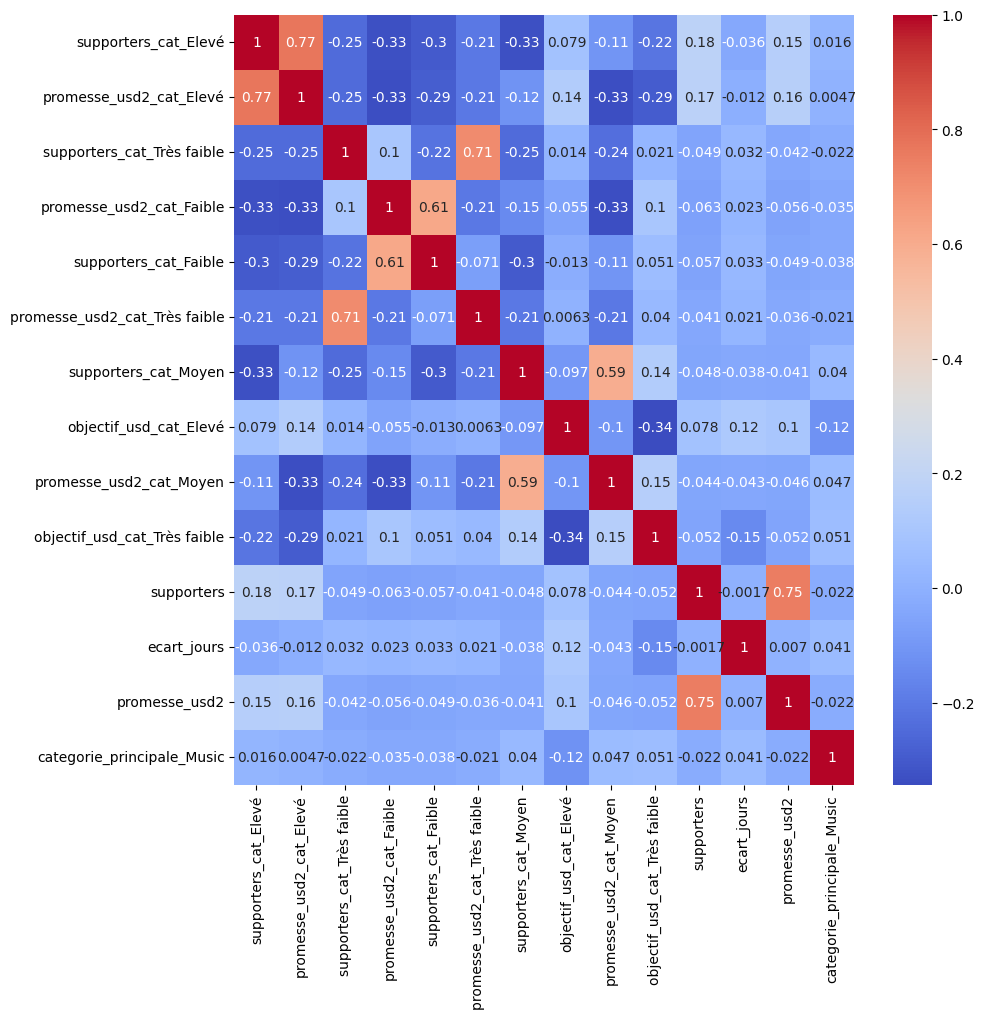

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(financement_df[X_columns].corr(), annot=True, cmap="coolwarm", ax=ax)
plt.show()

In [44]:
# On sépare les features et la variable cible en deux DataFrames X et y
X = financement_df[X_columns]
y = financement_df['etat_int']

# On utilise la fonction train_test_split de scikit-learn pour diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# On utilise StandardScaler pour centrer et réduire les données d'entraînement, puis appliquer la même transformation aux données de test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# On crée un modèle de régression logistique et on l'entraîne sur les données d'entraînement normalisées
model = LogisticRegression() # Ici j'utilise une LogisticRegression, à vous de tester d'autres modèles (pensez à importer le modèle plus haut !)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # On utilise le modèle pour prédire la variable cible y_test à partir des features X_test

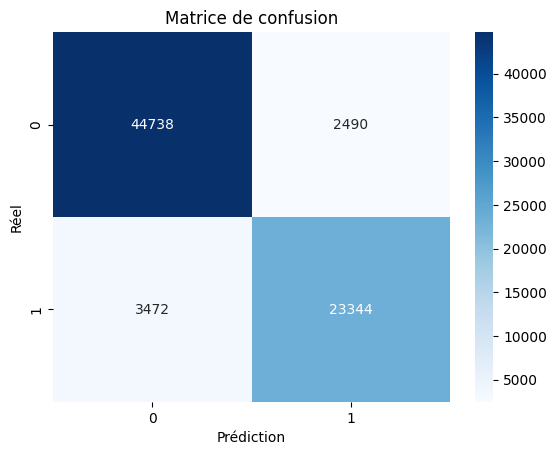

In [45]:
# On calcule la matrice de confusion pour évaluer les performances du modèle
conf_matrix = confusion_matrix(y_test, y_pred)

# On affiche la matrice de confusion sous forme de heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

La classe 0 (projets ayant échoué) est représentée par la première colonne et la première ligne de la matrice. Il y a 44738 échantillons de cette classe qui ont été prédits correctement (vrais négatifs) et 2490 qui ont été prédits incorrectement (faux positifs).

La classe 1 (projets ayant réussi) est représentée par la deuxième colonne et la deuxième ligne de la matrice. Il y a 23344 échantillons de cette classe qui ont été prédits correctement (vrais positifs) et 3472 qui ont été prédits incorrectement (faux négatifs).

In [46]:
class_report = classification_report(y_test, y_pred) # On affiche le classification report pour avoir un aperçu détaillé des performances du modèle par classe.
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     47228
           1       0.90      0.87      0.89     26816

    accuracy                           0.92     74044
   macro avg       0.92      0.91      0.91     74044
weighted avg       0.92      0.92      0.92     74044



Le modèle a une précision de 93% pour la classe 0 (projets ayant échoué) et 56% pour la classe 1 (projets ayant réussi).

Le modèle a un rappel (taux de vrais positifs) de 95% pour la classe 0 et 87% pour la classe 1. Cela signifie que le modèle identifie bien la majorité des projets qui échouent, et est un peu moins performant pour les modèles qui réussissent.

Le f1-score du modèle est de 0.94 pour la classe 0 et de 0.89 pour la classe 1, ce qui montre que le modèle est légèrement plus performant pour la prédiction des projets qui échouent.

L'accuracy score du modèle est de 92%, ce qui est plutôt bon. Cela signifie que le modèle prédit correctement la classe de 92% des projets de l'ensemble de test.

In [47]:
# Récupére les coefficients et les noms de variables
coefs = model.coef_[0]
variable_names = X_columns

# Créé un DataFrame pour stocker les coefficients et les noms de variables
coefficients_df = pd.DataFrame({'Variable': variable_names, 'Coefficient': coefs})

# Trie les coefficients par ordre décroissant de valeur absolue
coefficients_df['AbsoluteCoefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values('AbsoluteCoefficient', ascending=False).drop('AbsoluteCoefficient', axis=1)

print(coefficients_df)

                         Variable  Coefficient
12                  promesse_usd2     6.026157
1         promesse_usd2_cat_Elevé     3.419239
0            supporters_cat_Elevé     2.974789
8         promesse_usd2_cat_Moyen     2.489679
6            supporters_cat_Moyen     2.462866
9    objectif_usd_cat_Très faible     1.795935
7          objectif_usd_cat_Elevé    -1.745457
4           supporters_cat_Faible     1.614346
3        promesse_usd2_cat_Faible     1.344712
2      supporters_cat_Très faible     0.903681
5   promesse_usd2_cat_Très faible     0.617592
10                     supporters     0.590918
13     categorie_principale_Music     0.256808
11                    ecart_jours    -0.245198
